In [2]:
import proplot as pplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask as rmask
import cartopy.crs as ccrs
from scipy.optimize import curve_fit
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
from matplotlib_scalebar.scalebar import ScaleBar

# Map making

In [5]:
mt_pleasant_vector = gpd.read_file('./Data/site_validation/mt_pleasant_vector.shp')
mt_pleasant_mean_obs = pd.read_csv('./Data/site_validation/mt_pleasant_mean_obs.csv')
mt_pleasant_median = rio.open('./Data/site_validation/mt_pleasant_median.tif', 'r')
mt_pleasant_defol = rio.open('./Data/site_validation/mt_pleasant_defol.tif', 'r')
mt_pleasant_normal = rio.open('./Data/site_validation/mt_pleasant_normal.tif', 'r')

In [6]:
mt_pleasant_median_data = mt_pleasant_median.read()
mt_pleasant_median_data = mt_pleasant_median_data.transpose([1, 2, 0])

mt_pleasant_defol_data = mt_pleasant_defol.read()
mt_pleasant_defol_highlight = (mt_pleasant_defol_data < -0.2).astype(int)
mt_pleasant_defol_highlight = np.ma.masked_where(mt_pleasant_defol_highlight == 0, mt_pleasant_defol_highlight)

mt_pleasant_normal_data = mt_pleasant_normal.read()
mt_pleasant_normal_data = mt_pleasant_normal_data.transpose([1, 2, 0])

mt_pleasant_mean_obs['date'] = pd.to_datetime(mt_pleasant_mean_obs['date'])
mt_pleasant_mean_obs['doy'] = mt_pleasant_mean_obs['date'].dt.day_of_year
mt_pleasant_mean_obs = mt_pleasant_mean_obs.dropna().reset_index()

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


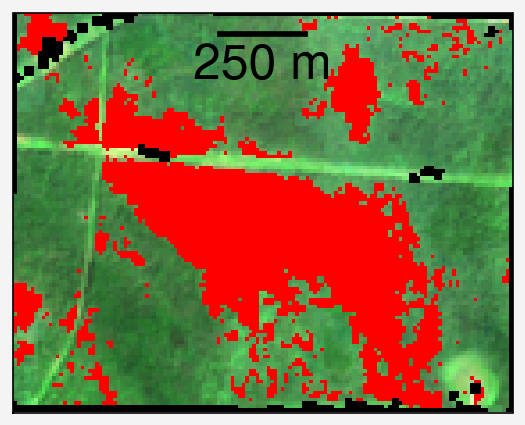

In [22]:
local_proj = ccrs.epsg(32618)
fig, ax = pplt.subplots(nrows=1, ncols=1, proj=local_proj)

ax.format(abcloc='ul', abcbbox=True)

## True color image with marked defoliation overlayed
ax.imshow(mt_pleasant_median_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], 
               origin='upper', transform=local_proj)
ax.imshow(mt_pleasant_defol_highlight[0], origin='upper', 
               extent=[mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], transform=local_proj, color='red')
ax.set_extent([mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], crs=local_proj)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                               250, '250 m', 'upper center', 
                           pad=0.3,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

# TODO: Look into Journal Figure requirements and reformat to better fit
fig.savefig('./Figures/abstract_1.png')

In [23]:
outbreaks = pd.read_csv('./Data/outbreak_centroids.csv')

In [24]:
outbreaks = outbreaks[outbreaks['label'] == 1].reset_index()
outbreaks['area'] = 100*outbreaks['count']
outbreaks['perimeter'] = 10*outbreaks['sum']
outbreaks['ratio'] = outbreaks['perimeter'] / outbreaks['area']

In [25]:
def f_mm(x, V_max, K_m):
    return V_max*x / (K_m + x)

def f_sqrt(x, a, b):
    return b*np.sqrt(x)+a

def f_lin(x, a, b):
    return b*x + a

def f_free(x, a, b, c):
    return b*(x**c) + a

In [26]:
# Specify size range of interest
min_size = 500
max_size = 40000

# Fit curve to perimeter/area relationship
small_outbreaks = outbreaks[(outbreaks['area'] > min_size) & (outbreaks['area'] < max_size)].reset_index()
popt_sqrt, _ = curve_fit(f_sqrt, small_outbreaks['area'], small_outbreaks['perimeter'])
popt_lin, _ = curve_fit(f_lin, small_outbreaks['area'], small_outbreaks['perimeter'])
popt_free, _ = curve_fit(f_free, small_outbreaks['area'], small_outbreaks['perimeter'])
pred_area = np.linspace(min_size, max_size, 200)
pred_perimeter_sqrt = f_sqrt(pred_area, *popt_sqrt)
pred_perimeter_lin = f_lin(pred_area, *popt_lin)
pred_perimeter_free = f_free(pred_area, *popt_free)

# Specify theortetical minimum of "perfect circle"
radius = np.linspace(np.sqrt(min_size / np.pi), np.sqrt(max_size / np.pi))
circle_area = np.pi*radius**2
circle_perimeter = 2*np.pi*radius

# Specify observable maximum for 4-way connectedness (straight line of height 1, length n)
length = np.arange(min_size / 100, max_size / 100)
line_area = length*100
line_perimeter = length*2*10 + 2*10

# Specify observable maximum for 8-way connectedness (diagonal line, length and height n)
diagonal_area = length*100
diagonal_perimeter = length*4*10

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


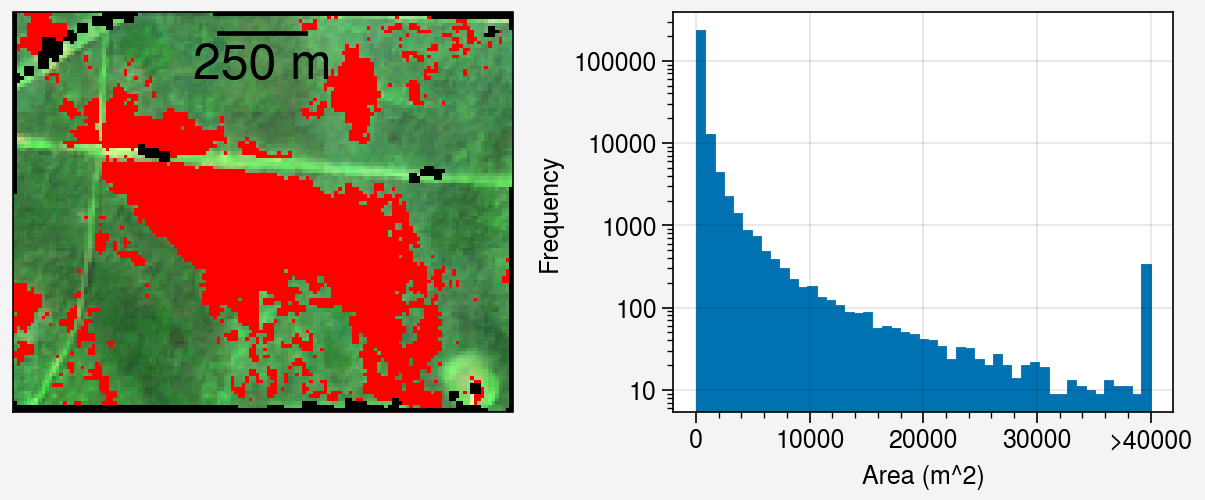

In [50]:
local_proj = ccrs.epsg(32618)
fig, axes = pplt.subplots(nrows=1, ncols=2, proj={1:local_proj})

axes.format(abcloc='ul', abcbbox=True)

## True color image with marked defoliation overlayed
axes[0].imshow(mt_pleasant_median_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[0].imshow(mt_pleasant_defol_highlight[0], origin='upper', 
               extent=[mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], transform=local_proj, color='red')
axes[0].set_extent([mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], crs=local_proj)

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(axes[0].transData,
                               250, '250 m', 'upper center', 
                           pad=0.3,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)

bin_edges = np.linspace(0, max_size, 50)
axes[1].hist(np.clip(outbreaks['area'], bin_edges[0], bin_edges[-1]), bins=bin_edges)
#axes[1].hist(small_outbreaks['area'], bins=50)
axes[1].format(xlabel='Area (m^2)', ylabel='Frequency', yscale='log', xticklabels=['0', '10000', '20000', '30000', '>40000'], xlocator=[0, 10000, 20000, 30000, 40000])

# TODO: Look into Journal Figure requirements and reformat to better fit
fig.savefig('./Figures/abstract_2.png')

C:\Users\camer\anaconda3\envs\bioee6550\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


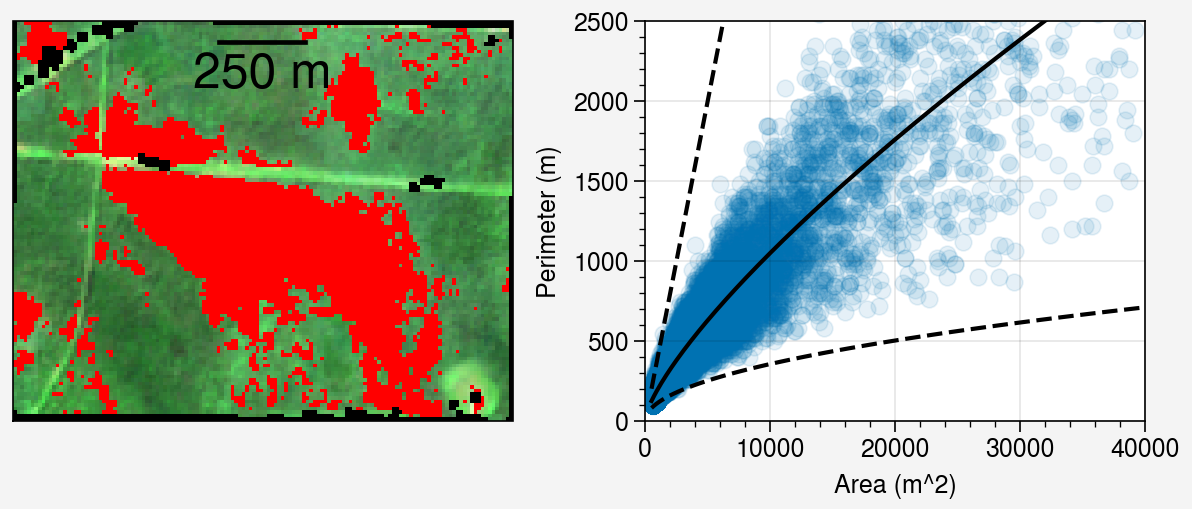

In [32]:
local_proj = ccrs.epsg(32618)
fig, axes = pplt.subplots(nrows=1, ncols=2, proj={1:local_proj})

axes.format(abcloc='ul', abcbbox=True)

## True color image with marked defoliation overlayed
axes[0].imshow(mt_pleasant_median_data / np.nanmax(mt_pleasant_normal_data), 
               extent=[mt_pleasant_median.bounds.left, mt_pleasant_median.bounds.right, mt_pleasant_median.bounds.bottom, mt_pleasant_median.bounds.top], 
               origin='upper', transform=local_proj)
axes[0].imshow(mt_pleasant_defol_highlight[0], origin='upper', 
               extent=[mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], transform=local_proj, color='red')
axes[0].set_extent([mt_pleasant_defol.bounds.left, mt_pleasant_defol.bounds.right, mt_pleasant_defol.bounds.bottom, mt_pleasant_defol.bounds.top], crs=local_proj)

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(axes[0].transData,
                               250, '250 m', 'upper center', 
                           pad=0.3,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)

axes[1].scatter(small_outbreaks['area'], small_outbreaks['perimeter'], alpha=0.1)
axes[1].plot(circle_area, circle_perimeter, color='black', linestyle='dashed')
axes[1].plot(diagonal_area, diagonal_perimeter, color='black', linestyle='dashed')
axes[1].plot(pred_area, pred_perimeter_free, color='black')
axes[1].format(xlim=[0, max_size], ylim=[0,2500], xlabel='Area (m^2)', ylabel='Perimeter (m)')

# TODO: Look into Journal Figure requirements and reformat to better fit
fig.savefig('./Figures/abstract_3.png')

In [51]:
axes[0]

GeoAxesSubplot(index=(0, 0), number=1, backend='cartopy')

In [52]:
axes

SubplotGrid(nrows=1, ncols=2, length=2)

In [56]:
(outbreaks['count']*100).std()

27463.93126029234

In [64]:
np.count_nonzero(outbreaks['count']*100 > 0)

262984